In [1]:
import os
import sys
import yaml
import seaborn
import pycountry
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from pathlib import Path
from copy import deepcopy
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch

sys.path.append(str(Path.cwd()))

from plotting_constants import coarse_regions
idx = pd.IndexSlice

with open(Path.cwd().parent / "config" / "config.yaml", "r") as f:
    tech_colors = yaml.safe_load(f)["plotting"]["tech_colors"]

In [2]:
root = Path.cwd().parent.parent.parent / "cluster_data"

carrier_mapper = {
    "elec": "geothermal heat elec",
    "chp": "geothermal heat chp elec",
    "dh": "geothermal heat dh",
}


def get_data(mode, op, process=True):

    header = [4,5,6,7,8]
    if mode == "chp" or mode == "dh":
        df = pd.read_csv(
            root / f"{mode}_data" / 
            "nodal_capacities.csv", 
            index_col=[0,1,2], 
            header=header,
            )
    elif mode == "elec":
        df = pd.read_csv(
            root / f"{mode}_data" / "nodal_capacities.csv",
            index_col=[0,1,2],
            header=header,
            )
    
    if process:

        df.index = df.index.droplevel(0)
        df = df.loc[idx[:, carrier_mapper[mode]], idx[:,:,op]]

        df.index = df.index.get_level_values(0)
        df.columns = df.columns.get_level_values(0)

    return df

df = get_data("dh", "static", process=False).loc[:, idx[:,:, "static"]]

df = df.loc[~df.index.get_level_values(1).isna()]
df.columns = df.columns.get_level_values(0)

index = df.index.to_frame()
index.index = index.index.get_level_values(2)
df = df.groupby(level=2).sum()

def get_component(carrier):
    value = index.loc[carrier, 0]
    if isinstance(value, str):
        return value
    else:
        return value.values[0]

df.index = pd.MultiIndex.from_tuples([(get_component(carrier), carrier) for carrier in df.index])

In [3]:
units = {
    "generators": "GW",
    "links": "GW",
    "stores": "GWh",
    }

drop_thresholds = {
    "generators": 0.1,
    "links": 0.1,
    "stores": 10,
}

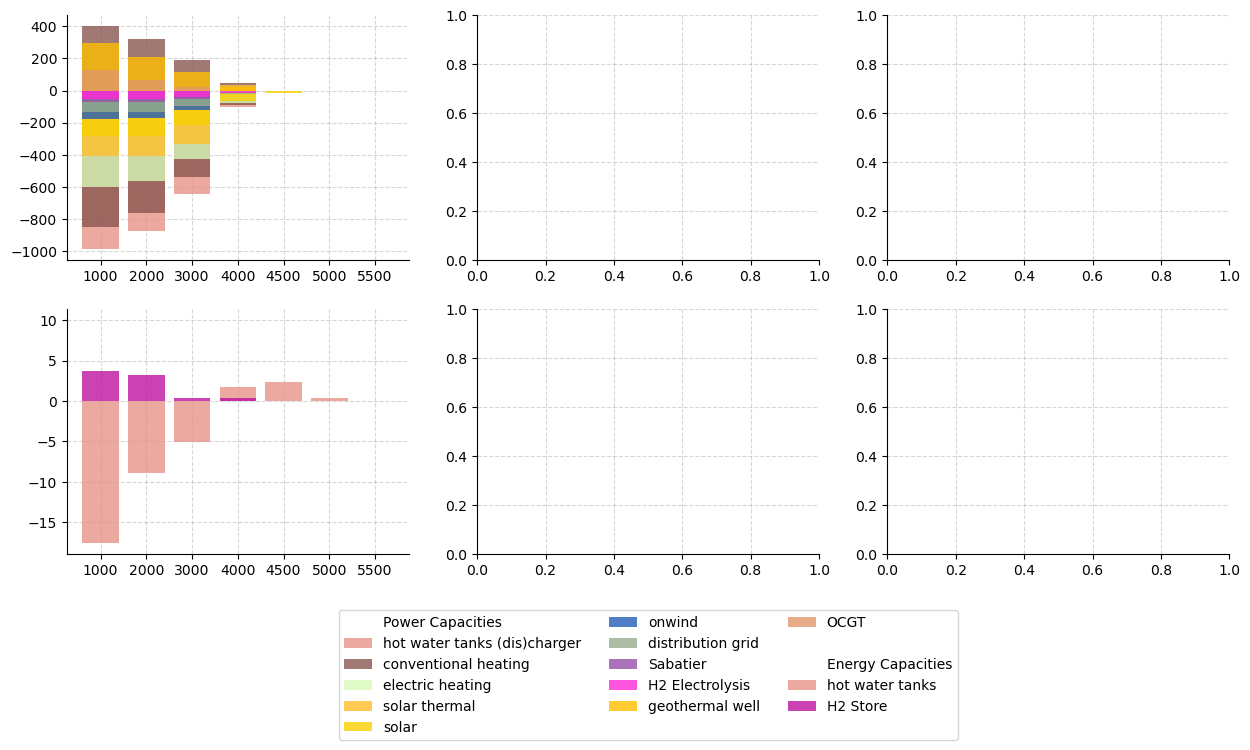

In [4]:
base_col = df.columns[-1]

cap_threshold = 10 # GW
energy_threshold = 0.1 # TWh

diff = df.subtract(df[base_col], axis=0).drop(base_col, axis=1)

fig, axs = plt.subplots(2, 3, figsize=(15, 7))

def maybe_add(elements, new_element):
    
        for element in elements:
            if element.get_label() == new_element.get_label():
                return

        elements.append(new_element)

bar_kwargs = {
    "alpha": 0.8,
}

drops = [
    "injection geothermal heat",
    "geothermal heat dh",
    ]
renames = {
    "production geothermal heat": "geothermal well",
    "electricity distribution grid": "distribution grid",
    "urban central solar thermal": "solar thermal",
}
groups = {
    "electric heating": [
        "urban central resistive heater",
        "urban central air heat pump",
        "residential urban decentral air heat pump",
    ],
    "conventional heating": [
        "urban central gas CHP",
        "urban central gas boiler",
        "urban central solid biomass CHP CC",
        "services urban decentral gas boiler",
        "residential urban decentral gas boiler",
        "services urban decentral biomass boiler",
        "residential urban decentral biomass boiler",
    ],
    "hot water tanks": [
        "urban central water tanks",
    ],
    "hot water tanks (dis)charger": [
        "urban central water tanks charger",
        "residential urban decentral water tanks (dis)charger",
    ]
}


def prepare_cap(cap, drops, renames, groups):
    cap = cap.drop(cap.index.intersection(drops))

    cap.index = [renames.get(name, name) for name in cap.index]

    for group, members in groups.items():
        
        if not len(cap.index.intersection(members)):
            continue

        inter = cap.index.intersection(members)
        cap.loc[group] = cap.loc[inter].sum()
        cap = cap.drop(inter)
    
    return cap


cap_legend = [
    Patch(facecolor="white", label="Power Capacities"),
    ]
energy_legend = [
    Patch(facecolor="white", label=""),
    Patch(facecolor="white", label="Energy Capacities"),
]


for col in df.columns[:-1]:

    cap = diff.loc[diff.index.get_level_values(0).isin(["generators", "links"]), col].mul(1e-3)

    cap = cap[cap.abs() > cap_threshold]
    cap.index = cap.index.droplevel(0)

    cap = cap.loc[~cap.index.str.contains("discharger")]
    renamer = {name: name for name in cap.index}
    renamer.update(
        {"residential urban decentral water tanks charger": "residential urban decentral water tanks (dis)charger"}
    )
    cap.index = [renamer[name] for name in cap.index]

    cap_neg = cap[cap < 0]
    cap_pos = cap[cap > 0]

    cap_neg = prepare_cap(cap_neg, drops, renames, groups)
    cap_pos = prepare_cap(cap_pos, drops, renames, groups)

    cap_neg = cap_neg.cumsum()
    cap_pos = cap_pos.cumsum()

    if not cap_neg.empty:
        for i, (name, value) in enumerate(cap_neg.iloc[::-1].items()):
            axs[0, 0].bar(str(col), value, bottom=0, label=name, color=tech_colors[name], **bar_kwargs)
            maybe_add(cap_legend, Patch(facecolor=tech_colors[name], label=name, **bar_kwargs))

    else:
        axs[0,0].bar(str(col), 0)

    if not cap_pos.empty:

        for i, (name, value) in enumerate(cap_pos.iloc[::-1].items()):
            axs[0,0].bar(str(col), value, bottom=0, label=name, color=tech_colors[name], **bar_kwargs)
            maybe_add(cap_legend, Patch(facecolor=tech_colors[name], label=name, **bar_kwargs))

    else:
        axs[0,0].bar(str(col), 0)

    energy = diff.loc[idx["stores", :], col].mul(1e-6)

    energy = energy[energy.abs() > energy_threshold]
    energy = energy.loc[idx["stores"]]#, ["urban central water tanks"]]]
    energy = energy.loc[~energy.index.isin(["gas", "oil", "methanol"])]

    energy_neg = energy[energy < 0]
    energy_pos = energy[energy > 0]

    energy_neg = prepare_cap(energy_neg, drops, renames, groups)
    energy_pos = prepare_cap(energy_pos, drops, renames, groups)

    energy_neg = energy_neg.cumsum()
    energy_pos = energy_pos.cumsum()

    if not energy_neg.empty:

        for i, (name, value) in enumerate(energy_neg.iloc[::-1].items()):
            axs[1,0].bar(str(col), value, bottom=0, label=name, color=tech_colors[name], **bar_kwargs)
            maybe_add(energy_legend, Patch(facecolor=tech_colors[name], label=name, **bar_kwargs))
    
    else:
        axs[1,0].bar(str(col), 10, alpha=0.)

    if not energy_pos.empty:

        for i, (name, value) in enumerate(energy_pos.iloc[::-1].items()):
            axs[1,0].bar(str(col), value, bottom=0, label=name, color=tech_colors[name], **bar_kwargs)
            maybe_add(energy_legend, Patch(facecolor=tech_colors[name], label=name, **bar_kwargs))



axs[1,1].legend(
    handles=cap_legend + energy_legend,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),
    fancybox=True,
    shadow=False,
    ncol=3,
    )

for ax in axs.flatten():
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.set_axisbelow(True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


plt.show()

In [ ]:
diff.loc[idx[]]